In [1]:
import torch
import cv2
import numpy as np
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.optim.lr_scheduler as lr_scheduler
import random
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
from os import path
from PIL import Image

In [2]:
# model
out_dim = 8
num_features = 8

# environment
device = 'cuda' # if don't have GPU, turn 'cpu'
random_seed = 0

# dataset
label_csv_path = '/home/dw-dengwei/dataset/tissue/test.csv'
image_root = '/home/dw-dengwei/dataset/tissue/test/'
output_pred = '/home/dw-dengwei/dataset/tissue/predict.csv'

# experiment
test_batch_size = 1024
save_path = "save/checkpoint128.pth"
TEST = True

# fix random seed
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
# load label and id into memory
label_dataframe = pd.read_csv(label_csv_path)
label_db = {}
ids = []
for index, rows in label_dataframe.iterrows():
    idx, label = rows['Id'], rows['Cell type']
    label_db[str(idx)] = label
    ids.append(str(idx))

test_ids = ids

In [4]:
# Dataset class
class Cell(Dataset):
    def __init__(self, 
                 ids: list, 
                 label_db: dict, 
                 image_root: str, 
        ) -> None:
        '''
        ids: indexes of the training/validating data
        label_db: dict structure of train.csv file
        image_root: image root path
        '''

        self.num = len(ids)
        self.label = []
        self.image = []
        self.ids = []

        # These operations may cause large memory in runtime and time use at start.
        # Using database file is recommended.
        for idx in ids:
            target = label_db[idx]
            img_cv = cv2.imread(path.join(image_root, str(idx).rjust(5, '0') + ".jpg"))
            img = self.transform(img_cv)
            self.label.append(target)
            self.image.append(img)
            self.ids.append(idx)

    def __len__(self) -> int:
        return self.num

    def __getitem__(self, index):
        return self.image[index], self.label[index], int(self.ids[index])

    def transform(self, img_cv) -> torch.Tensor:
        img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
        tf = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x[0:1, :, :]),
            ])
        return tf(img_pil)


# model structure
class Toy(nn.Module):
    def __init__(self, num_feature, num_classes):
        super().__init__()
        self.num_feature=num_feature
        self.layer = nn.Sequential(
            self.make_layer(1, self.num_feature, is_pooling=False),
            self.make_layer(self.num_feature, self.num_feature, is_pooling=False),
            self.make_layer(self.num_feature, self.num_feature, is_pooling=False),

            self.make_layer(self.num_feature, self.num_feature * 2),
            self.make_layer(self.num_feature * 2, self.num_feature * 2, is_pooling=False),

            self.make_layer(self.num_feature * 2, self.num_feature * 4),

            self.make_layer(self.num_feature * 4, self.num_feature * 8),

            self.make_layer(self.num_feature * 8, self.num_feature * 16, is_pooling=False),
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(self.num_feature * 16 * 3 * 3, self.num_feature * 16),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(self.num_feature * 16, num_classes)
        )    
                
        
    def make_layer(self, 
                   in_channels, 
                   out_channels,
                   is_pooling=True,
                   kernel_size=3, 
                   stride=1, 
                   padding=1):
        layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        if is_pooling:
            layers.add_module('pooling', nn.AvgPool2d(2, 2))
        return layers


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layer(x)
        return x

In [5]:
@torch.no_grad()
def evaluate(model: nn.Module, dataloader: DataLoader, device):
    model.eval()
    y_hat = torch.Tensor()
    y_true = torch.Tensor()
    ids_out = torch.Tensor()
    for iter, batch in enumerate(dataloader):
        image, label, idx = batch
        image = image.to(torch.device(device))
        label = label.to(torch.device(device))
        predict = model.forward(image)
        y_hat = torch.concat((y_hat, predict.to('cpu')), dim=0)
        y_true = torch.concat((y_true, label.to('cpu')), dim=0)
        ids_out = torch.concat((ids_out, idx))
    
    return y_hat, y_true, ids_out

In [6]:
# model
print('model')
model = Toy(num_feature=num_features, num_classes=out_dim)
# load checkpoint before test
print('load checkpoint')
model.load_state_dict(torch.load(save_path))
model = model.to(device=device)
# dataset and dataloader
print('dataset and dataloader')
dataset_test = Cell(test_ids, label_db, image_root,)
dataloader = DataLoader(dataset_test, test_batch_size, shuffle=True)

model
load checkpoint
dataset and dataloader


In [7]:
y_hat, y_true, ids_out = evaluate(model, dataloader, device)
pred = torch.argmax(y_hat, dim=1).numpy().reshape(-1, 1)
ids_out = ids_out.numpy().reshape(-1, 1)
data = np.concatenate((ids_out, pred), axis=1)
predict_dataframe = pd.DataFrame(data=data, columns=['Id', 'Cell type'], dtype=int).sort_values(by='Id')
predict_dataframe.to_csv(output_pred, index=False)
predict_dataframe.to_csv('test/predict.csv', index=False)

# metric functions

In [8]:
import torch
import sklearn.metrics as skm
import torch.nn as nn
from sklearn.preprocessing import label_binarize

'''
Define new metrics for training here. While all metrics in the config are tracked, only the monitor metric is used for determining the model's best performance
'''
def confusion_matrix(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        cm = skm.confusion_matrix(target, pred)
    return cm


def accuracy(output, target): #accuracy
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        correct = 0
        correct += torch.sum(pred == target).item()
    return correct / len(target)

def f1(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        f1_c = 0
        f1_c = skm.f1_score(target.detach().numpy(), pred, average = 'macro')
    return f1_c

def roc_auc(output, target, multi_class):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        roc = 0
        roc = skm.roc_auc_score(
            target.detach().numpy(),
            label_binarize(pred.numpy(), classes=[i for i in range(8)]), 
            multi_class=multi_class, 
            average='macro'
        )
    return roc

def recall(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        f1_c = 0
        f1_c = skm.recall_score(target.detach().numpy(), pred, average = 'macro')
    return f1_c

def precision(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        f1_c = 0
        f1_c = skm.precision_score(target.detach().numpy(), pred, average = 'macro')
    return f1_c

def balanced_accuracy(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        f1_c = 0
        f1_c = skm.balanced_accuracy_score(target.detach().numpy(), pred)
    return f1_c

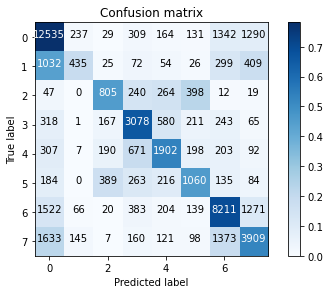

****************************************
confusion matrix
[[12535   237    29   309   164   131  1342  1290]
 [ 1032   435    25    72    54    26   299   409]
 [   47     0   805   240   264   398    12    19]
 [  318     1   167  3078   580   211   243    65]
 [  307     7   190   671  1902   198   203    92]
 [  184     0   389   263   216  1060   135    84]
 [ 1522    66    20   383   204   139  8211  1271]
 [ 1633   145     7   160   121    98  1373  3909]]
****************************************
accuracy
0.6387
****************************************
f1
0.5426414882526766
****************************************
recall
0.5356310069247834
****************************************
precision
0.5678832541919969
****************************************
balanced_accuracy
0.5356310069247834


In [9]:
import matplotlib.colors as colors
import itertools
metric = {
    "confusion matrix":  confusion_matrix(y_hat, y_true),
    "accuracy":          accuracy(y_hat, y_true),
    "f1":                f1(y_hat, y_true),
    "recall":            recall(y_hat, y_true),
    "precision":         precision(y_hat, y_true),
    "balanced_accuracy": balanced_accuracy(y_hat, y_true),
}
cm = confusion_matrix(y_hat, y_true)
cm_origin = cm.copy()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
plt.title('Confusion matrix')
plt.colorbar()
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm_origin.shape[0]), range(cm_origin.shape[1])):
    plt.text(j, i, format(cm_origin[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig("test/confusion.png", dpi=700, format='png')
plt.savefig("test/confusion.svg", format='svg')
plt.show()
for k, v in metric.items():
    print('*' * 40)
    print(k)
    print(v)

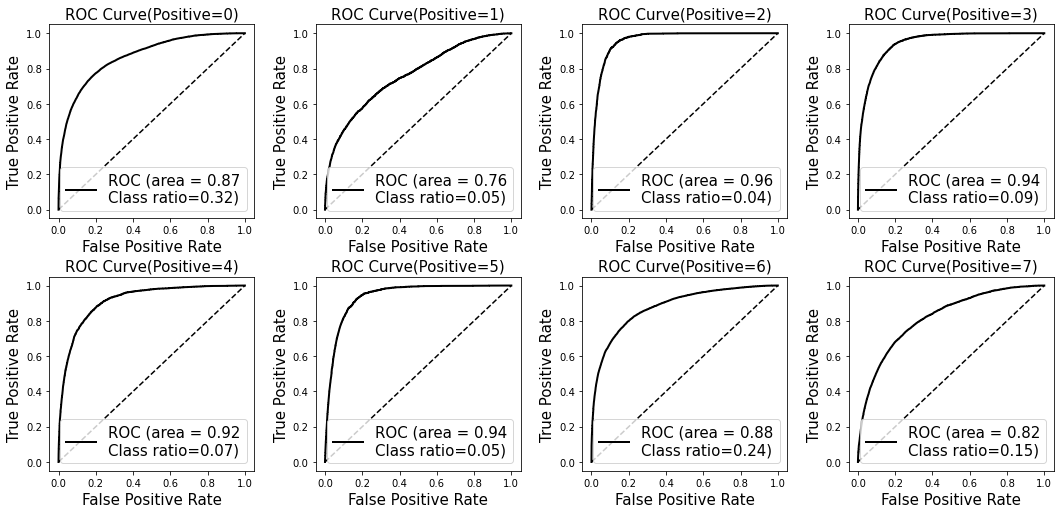

In [10]:
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=(18, 8))
class_ratio = [
    0.3205,
    0.0472,
    0.0356,
    0.0931,
    0.0713,
    0.0470,
    0.2374,
    0.1480,
]
for i in range(8):
    pred = torch.argmax(y_hat, dim=1)
    fpr, tpr, thersholds = roc_curve(y_true, y_hat[:, i], pos_label=i)
    
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(2, 4, i + 1)
    plt.plot(fpr, tpr, 'k', label='ROC (area = {0:.2f}\nClass ratio={1:.2f})'\
        .format(roc_auc, class_ratio[i]), lw=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate',  fontsize=15)
    plt.title(f'ROC Curve(Positive={i})', fontsize=15)
    plt.legend(loc="lower right", prop = {'size':15})


plt.subplots_adjust(left=0.125,
                    bottom=0.125, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
plt.savefig("test/roc.png", dpi=700, format='png')
plt.savefig("test/roc.svg", format='svg')
plt.show()